In [14]:
#Import libaries
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, ifft
from scipy.io import wavfile 
from scipy.signal import filtfilt, butter
from pylab import *
import os
import librosa

#Import self-written functions
from Denoise_Functions import *
from features_functions import *

# Loading in the data

In [15]:
#Get directories with data
dir_gearbox = os.path.join(os.getcwd(), 'gearbox')
dir_train = os.path.join(dir_gearbox, "train")
dir_test = os.path.join(dir_gearbox, "test")

In [16]:
# Extract anomoly files and normal files from the test set
anom_files = []
anom_sr = []
anom_data = []

norm_files = []
norm_sr = []
norm_data = []

# make a list of all the files in the training data folder that contain section_00 in the name and volt_1.0 in the name
for i in os.listdir(dir_test):
    if 'anomaly' in i and 'section_00' in i and 'volt_1.0' in i:
        anom_files.append(i)
        data, samplerate = librosa.load(dir_test + '\\' + i,sr=16000)
        # samplerate, data = wavfile.read(dir_test + '\\' + i)
        anom_sr.append(samplerate)
        anom_data.append(data)

    if 'normal' in i and 'section_00' in i and 'volt_1.0' in i:
        norm_files.append(i)
        data, samplerate = librosa.load(dir_test + '\\' + i,sr=16000)
        # samplerate, data = wavfile.read(dir_test + '\\' + i)
        norm_sr.append(samplerate)
        norm_data.append(data)

# Pre-Processing: smoothing the fft

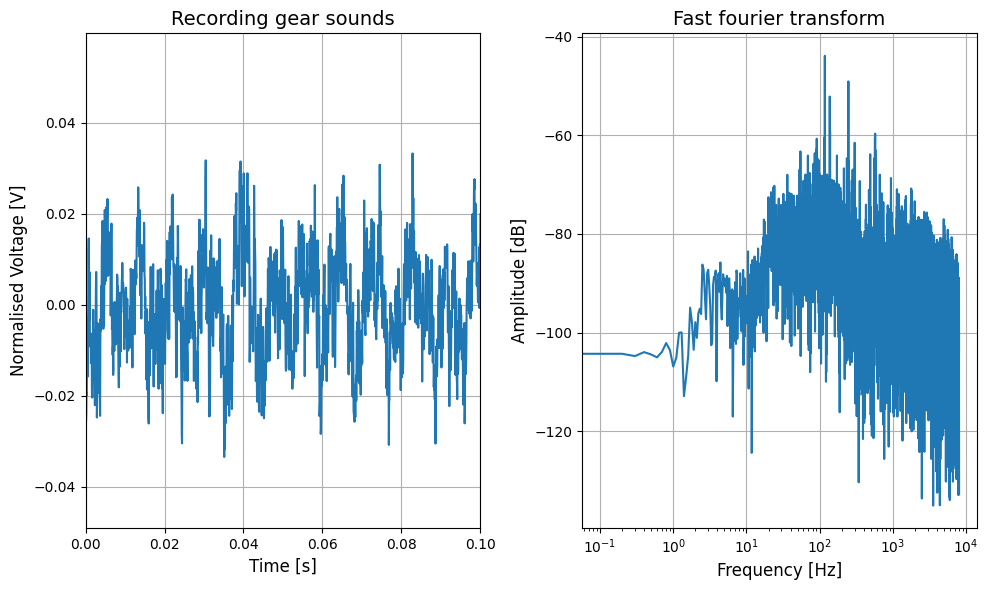

In [36]:
#Test for 1 file the smoothing
i=2

N = norm_data[i].shape[0]
t_end = N / norm_sr[i]

x = np.linspace(0., t_end, N)
y = norm_data[i]

#Get the fft from the data
yf_v1 = fft(y)
yf = 2.0/N * np.abs(yf_v1[0:N//2])
xf = fftfreq(N, t_end/N)[:N//2]

fig, ax = plt.subplots(1,2,figsize=(10, 6), tight_layout=True)
ax[0].plot(x,y)
ax[0].grid()
ax[0].set_xlabel(r'Time [s]', fontsize=12)
ax[0].set_ylabel(r'Normalised Voltage [V]', fontsize=12)
ax[0].set_title(r'Recording gear sounds', fontsize=14)
ax[0].set_xlim(0,0.1)

ax[1].plot(xf,20*np.log10(yf))
ax[1].set_xscale('log')
ax[1].grid()
ax[1].set_xlabel(r'Frequency [Hz]', fontsize=12)
ax[1].set_ylabel(r'Amplitude [dB]', fontsize=12)
ax[1].set_title(r'Fast fourier transform', fontsize=14)

plt.show()



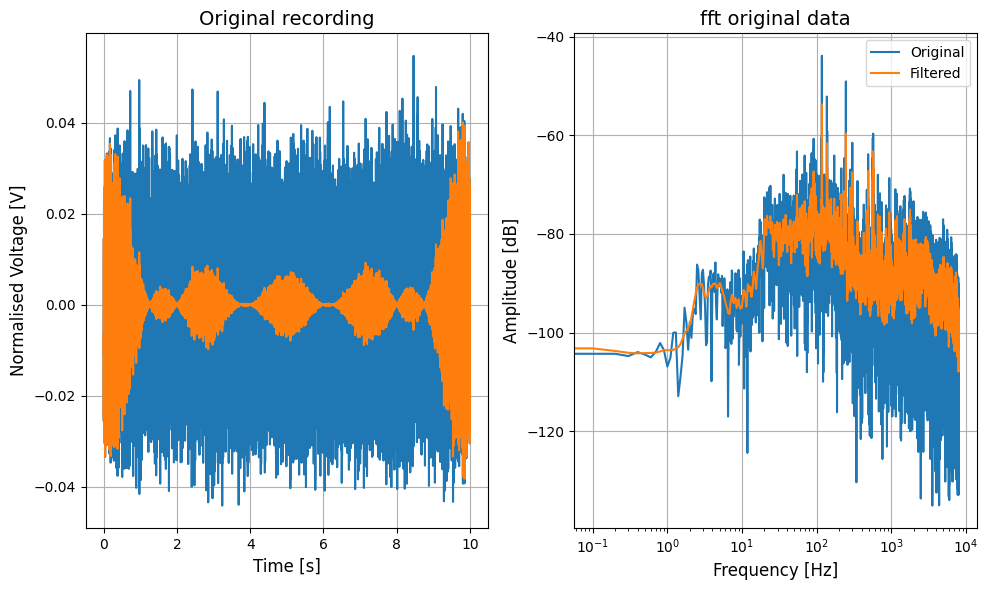

In [35]:
n = 5  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1

yf_filter = filtfilt(b, a, yf)
# yf_v1_filter =  filtfilt(b, a, yf_v1)
yf_v1_filter = lfilter(b, a, yf_v1)
y_filter = ifft(yf_v1_filter)

fig1, ax1 = plt.subplots(1,2,figsize=(10, 6), tight_layout=True)
ax1[1].plot(xf,20*np.log10(yf), label='Original')
ax1[1].plot(xf,20*np.log10(yf_filter), label='Filtered')
# ax1[1].set_yscale('log')
ax1[1].set_xscale('log')
ax1[1].grid()
ax1[1].set_xlabel(r'Frequency [Hz]', fontsize=12)
ax1[1].set_ylabel(r'Amplitude [dB]', fontsize=12)
ax1[1].set_title(r'fft original data', fontsize=14)
ax1[1].legend(loc='upper right') # ax1[1,0].plot(x,y_filter)

# ax1[1,1].plot(xf,yf_filter)
# ax1[1,1].set_yscale('log')
# ax1[1,1].grid()
# ax1[1,1].set_xlabel(r'Frequency [Hz]', fontsize=10)
# ax1[1,1].set_ylabel(r'Amplitude [dB]', fontsize=10)
# ax1[1,1].set_title(r'fft smoothen filter', fontsize=14)
# ax1[1,1].sharey(ax1[0,1])

ax1[0].plot(x,y)
ax1[0].plot(x,y_filter)
# ax1[0].set_xlim(2,2.1)
ax1[0].grid()
ax1[0].set_xlabel(r'Time [s]', fontsize=12)
ax1[0].set_ylabel(r'Normalised Voltage [V]', fontsize=12)
ax1[0].set_title(r'Original recording', fontsize=14)
# ax1[1,0].grid()
# ax1[1,0].set_xlabel(r'Time [s]', fontsize=10)
# ax1[1,0].set_ylabel(r'Normalised Voltage [V]', fontsize=10)
# ax1[1,0].set_title(r'Filtered recording', fontsize=14)
# ax1[1,0].sharey(ax1[0, 0])
plt.show()


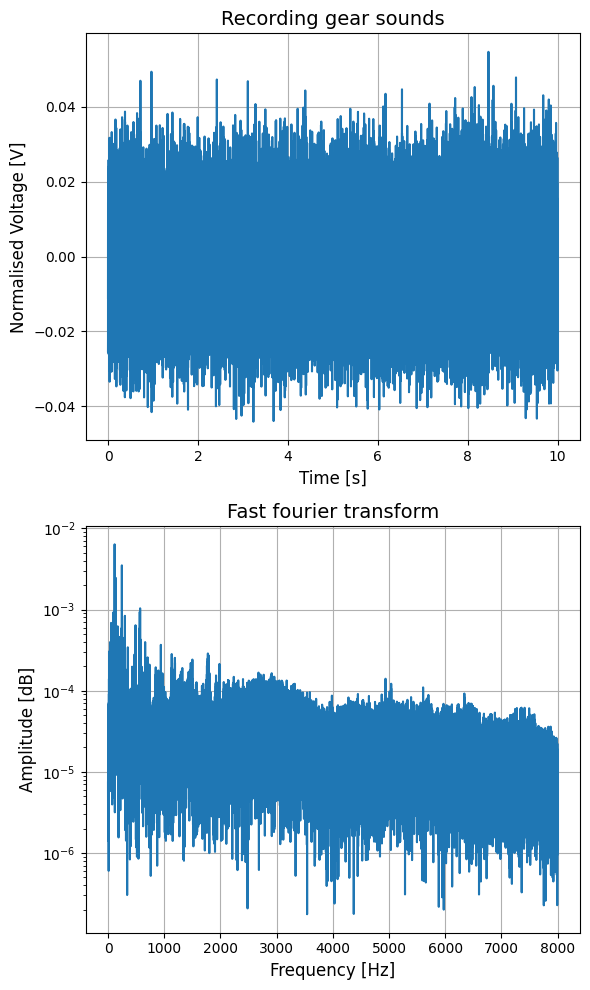

In [19]:
fig, ax = plt.subplots(2,1,figsize=(6, 10), tight_layout=True)
ax[0].plot(x,y)
ax[0].grid()
ax[0].set_xlabel(r'Time [s]', fontsize=12)
ax[0].set_ylabel(r'Normalised Voltage [V]', fontsize=12)
ax[0].set_title(r'Recording gear sounds', fontsize=14)

ax[1].plot(xf,yf)
ax[1].set_yscale('log')
ax[1].grid()
ax[1].set_xlabel(r'Frequency [Hz]', fontsize=12)
ax[1].set_ylabel(r'Amplitude [dB]', fontsize=12)
ax[1].set_title(r'Fast fourier transform', fontsize=14)

plt.show()

In [20]:
#Perform smoothing for all data
anom_data_denoised = smoothen_fft(anom_data,anom_sr)
norm_data_denoised = smoothen_fft(norm_data,norm_sr)

# Feature selection and extraction

In [21]:
# extract basic features
anom_means, anom_stds, anom_maxs, anom_mins, anom_medians = extract_basics(anom_data_denoised)
norm_means, norm_stds, norm_maxs, norm_mins, norm_medians = extract_basics(norm_data_denoised)

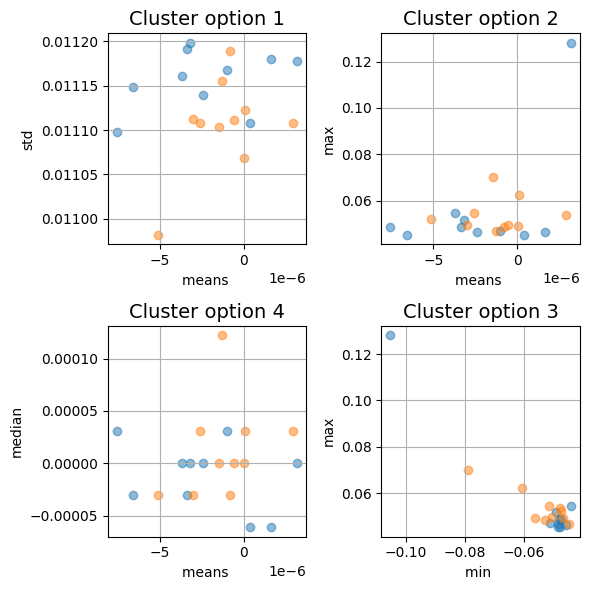

In [22]:
fig, ax = plt.subplots(2,2,figsize=(6,6), tight_layout=True)
ax[0,0].scatter(norm_means, norm_stds, alpha=0.5)
ax[0,0].scatter(anom_means, anom_stds, alpha=0.5)
ax[0,0].grid()
ax[0,0].set_xlabel(r'means ', fontsize=10)
ax[0,0].set_ylabel(r'std', fontsize=10)
ax[0,0].set_title(r'Cluster option 1', fontsize=14)

ax[0,1].scatter(norm_means, norm_maxs, alpha=0.5)
ax[0,1].scatter(anom_means, anom_maxs, alpha=0.5)
ax[0,1].grid()
ax[0,1].set_xlabel(r'means ', fontsize=10)
ax[0,1].set_ylabel(r'max', fontsize=10)
ax[0,1].set_title(r'Cluster option 2', fontsize=14)

ax[1,1].scatter(norm_mins, norm_maxs, alpha=0.5)
ax[1,1].scatter(anom_mins, anom_maxs, alpha=0.5)
ax[1,1].grid()
ax[1,1].set_xlabel(r'min ', fontsize=10)
ax[1,1].set_ylabel(r'max', fontsize=10)
ax[1,1].set_title(r'Cluster option 3', fontsize=14)

ax[1,0].scatter(norm_means, norm_medians, alpha=0.5)
ax[1,0].scatter(anom_means, anom_medians, alpha=0.5)
ax[1,0].grid()
ax[1,0].set_xlabel(r'means ', fontsize=10)
ax[1,0].set_ylabel(r'median', fontsize=10)
ax[1,0].set_title(r'Cluster option 4', fontsize=14)
plt.show()

Text(0.5, 1.0, 'Spectrogram')

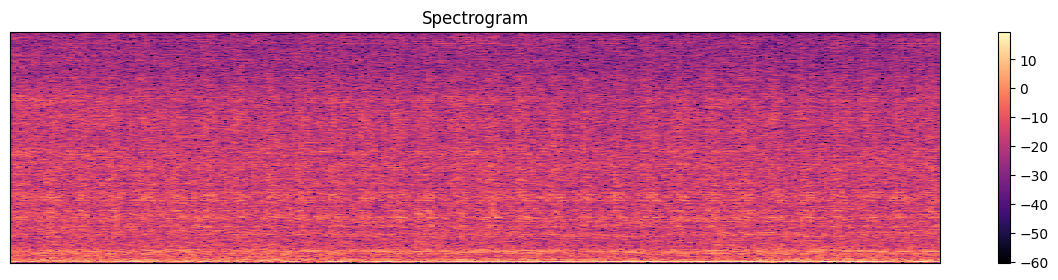

In [23]:
# generate spectrogram
anom_spec = spec(anom_data_denoised)
norm_spec = spec(norm_data_denoised)

# plot first spectrogram
plt.figure(figsize=(15, 3))
librosa.display.specshow(anom_spec[0])
plt.colorbar()
plt.title('Spectrogram')


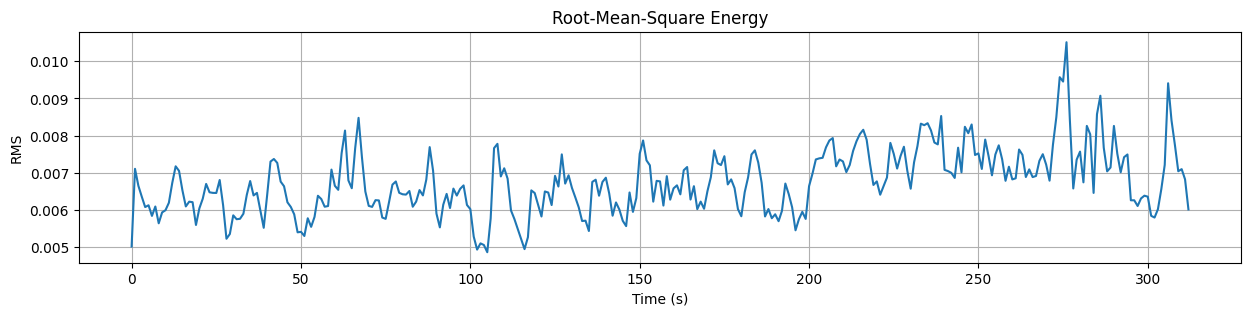

In [24]:
# extract RMS
anom_rms = rms(anom_data_denoised)
norm_rms = rms(norm_data_denoised)

# plot first RMS
plt.figure(figsize=(15, 3))
plt.plot(anom_rms[0][0])
plt.grid()
plt.title('Root-Mean-Square Energy')
plt.xlabel('Time (s)')
plt.ylabel('RMS')
plt.show()

Zero crossing rate: 35590


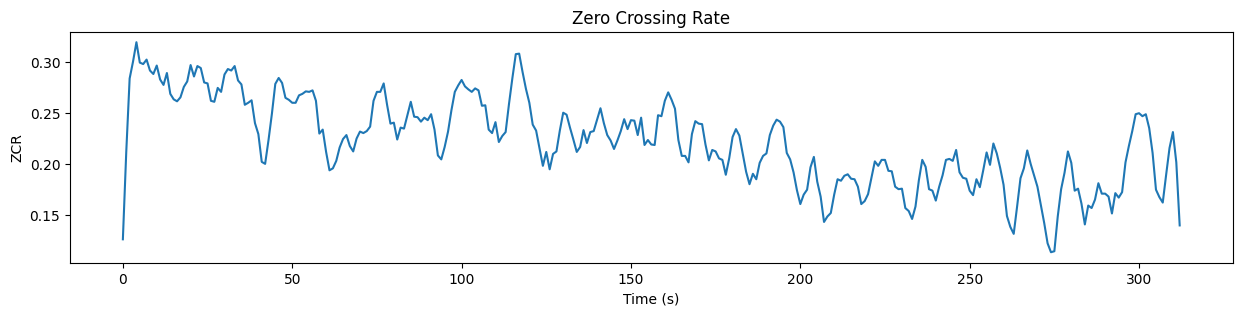

In [25]:
# extract ZCR

anom_zcr = zcr(anom_data_denoised)
norm_zcr = zcr(norm_data_denoised)
    
# plot first ZCR
print(f"Zero crossing rate: {sum(librosa.zero_crossings(anom_data_denoised[0]))}")

plt.figure(figsize=(15, 3))
plt.plot(anom_zcr[0][0])
plt.title('Zero Crossing Rate')
plt.xlabel('Time (s)')
plt.ylabel('ZCR')
plt.show()

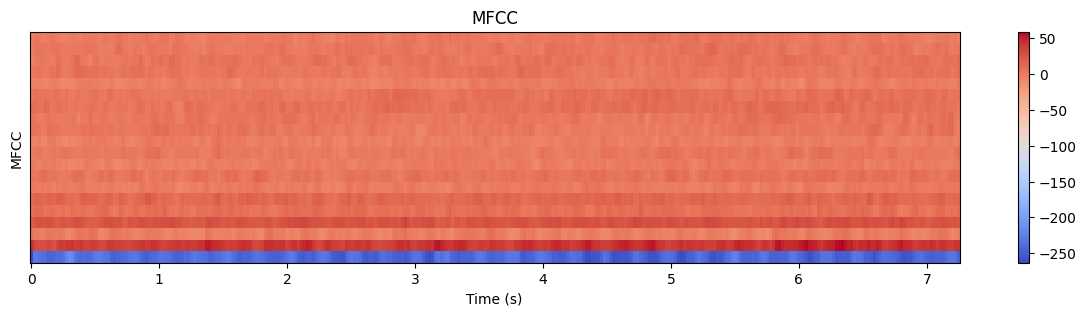

In [26]:
# extract MFCC

anom_mfcc = mfcc(anom_data_denoised)
norm_mfcc = mfcc(norm_data_denoised)

# plot first MFCC
plt.figure(figsize=(15, 3))
librosa.display.specshow(anom_mfcc[0], x_axis='time')
plt.title('MFCC')
plt.xlabel('Time (s)')
plt.ylabel('MFCC')
plt.colorbar()
plt.show()